<a href="https://colab.research.google.com/github/Paul-Bett/MLFC_Fynesse/blob/main/MLFC_Mini_Project_Fynessed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLFC Mini Project — Time-Series Analysis of Insect Count and Weather Data
This notebook performs: **Access → Assess → Address**.
- Access: load and parse insect-count log file + weather data into dataframes
- Assess: inspect, clean, visualize and align datasets by timestamps
- Address: train regression (and a classification-binned variant) models to predict insect count from weather; evaluate RMSE, R², MAE.

Goal:
- Parse insect-count logfile (snapshots every 10s): lines like:
  `Processed 20241002003529-snapshot.jpg - Insect count: 34`
- Load weather data (use your existing notebook's weather pipeline to produce `weather.csv` or supply a DataFrame).
- Align insect counts to nearest weather timestamp.
- Train regression models to predict insect count from weather features (report RMSE, R², MAE).

Abstract

This project develops and demonstrates an end-to-end Jupyter notebook pipeline for analyzing insect count data collected from automated monitoring systems in relation to weather variables. The pipeline begins with data ingestion and cleaning, merging insect count logs with environmental metadata. It proceeds through exploratory data analysis (EDA), including summary statistics, head/tail inspection, and visualizations of insect counts alongside temperature, humidity, and rainfall.

To account for scale and temporal granularity, the workflow introduces resampling and aggregation at multiple levels (10-second, 1-minute, 5-minute, and hourly), enabling interpretable insights into short- and long-term insect activity patterns.

For predictive modeling, the pipeline fits multiple regression models and evaluates them using RMSE, R², and MAE. Visualization functions plot predicted vs. true counts and residuals.

Altogether, this pipeline integrates EDA, temporal analysis, statistical modeling, and visualization into a reproducible framework. By combining insect activity with weather signals, it offers a practical tool for identifying ecological patterns, testing predictive models, and generating insights that can guide future monitoring, research, and conservation strategies.



# Imports & config

In [1]:
%%capture
%pip install osmnx

In [2]:
import os
import shutil
%cd /content
folder_to_delete = 'MLFC_Fynesse'

if os.path.exists(folder_to_delete):
    print(f"Deleting folder: {folder_to_delete}")
    shutil.rmtree(folder_to_delete)
    print(f"Folder '{folder_to_delete}' deleted.")
else:
    print(f"Folder '{folder_to_delete}' does not exist.")

/content
Deleting folder: MLFC_Fynesse
Folder 'MLFC_Fynesse' deleted.


In [3]:
repo_dir = 'MLFC_Fynesse'

if os.path.exists(repo_dir):
    print(f"Directory '{repo_dir}' already exists. Skipping cloning.")
else:
    !git clone https://github.com/Paul-Bett/MLFC_Fynesse.git
    print(f"Cloned repository into '{repo_dir}'.")




Cloning into 'MLFC_Fynesse'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 309 (delta 60), reused 6 (delta 6), pack-reused 222 (from 4)
Receiving objects: 100% (309/309), 291.70 KiB | 2.19 MiB/s, done.
Resolving deltas: 100% (154/154), done.
Cloned repository into 'MLFC_Fynesse'.


In [4]:
import os

fynesse_path = "/content/MLFC_Fynesse/fynesse"
if os.path.exists(fynesse_path):
    print(f"Contents of {fynesse_path}:")
    for item in os.listdir(fynesse_path):
        print(item)
else:
    print(f"Directory not found: {fynesse_path}")

Contents of /content/MLFC_Fynesse/fynesse:
config.py
assess.py
defaults.yml
access.py
tests
__init__.py
address.py


In [5]:
import os, subprocess, importlib, sys
import numpy as np
sys.path.append("/content/MLFC_Fynesse/")
import fynesse
from fynesse.access import *
from fynesse.assess import *
from fynesse.address import *






#  Environment setup

In [6]:
import sys, os
repo_dir = "/content/MLFC_Fynesse"
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

print("Working dir:", os.getcwd())
print("Repo path in sys.path:", repo_dir in sys.path)
# paths
LOG_PATH = '/content/MLFC_Fynesse/outputlogs1.txt'
# candidate weather files - we'll search for likely names
CANDIDATE_WEATHER_PATHS = [
    '/content/weather.csv',
    os.path.join(repo_dir, 'weather.csv'),
    os.path.join(repo_dir, 'data', 'weather.csv'),
    'weather.csv'
]

# helper to test availability of a symbol
def has(name):
    return name in globals() or name in locals()


Working dir: /content
Repo path in sys.path: True


# Access: parse insect log (calls your parsing functions)

In [7]:
print("Log path:", LOG_PATH)
if not os.path.exists(LOG_PATH):
    raise FileNotFoundError(f"Logfile not found at {LOG_PATH}. Put the file there or edit LOG_PATH.")


if 'load_text_log' in globals() and 'parse_insect_log_lines' in globals():
    lines = fynesse.access.load_text_log(LOG_PATH)
    print(f"Loaded {len(lines)} non-empty lines from log.")
    counts_df = fynesse.access.parse_insect_log_lines(lines)
    print("Parsed counts_df shape:", counts_df.shape)
    display(counts_df.head())
else:
    raise RuntimeError("Required functions load_text_log and/or parse_insect_log_lines are not defined in the namespace.")


Log path: /content/MLFC_Fynesse/outputlogs1.txt
Loaded 31280 non-empty lines from log.
Parsed counts_df shape: (31279, 2)


,timestamp,count
0,2024-09-20 18:39:09,4
1,2024-09-20 18:39:19,4
2,2024-09-20 18:39:29,4
3,2024-09-20 18:39:39,4
4,2024-09-20 18:39:49,3


# Access: locate/load weather (uses your loader or finds CSV; falls back to synthetic)

In [8]:
weather_df = None
used_synthetic_weather = False


if 'load_weather_from_your_pipeline' in globals():
    try:
        print("Trying load_weather_from_your_pipeline()...")
        weather_df = load_weather_from_your_pipeline()
        print("Loaded weather via pipeline function.")
    except Exception as e:
        print("Pipeline loader failed:", e)

if weather_df is None and 'load_weather_csv' in globals():
    for p in CANDIDATE_WEATHER_PATHS:
        if os.path.exists(p):
            try:
                print("Loading weather from:", p)
                weather_df = load_weather_csv(p)
                print("Loaded weather_df shape:", weather_df.shape)
                break
            except Exception as e:
                print("Failed to load", p, ":", e)


if weather_df is None:
    print("No weather CSV found. Creating synthetic weather DataFrame aligned to count timestamps (for demo only).")
    used_synthetic_weather = True
    idx = pd.to_datetime(counts_df['timestamp']).sort_values().unique()
    rng = np.random.RandomState(0)
    weather_df = pd.DataFrame({
        'temperature': 20 + 10*rng.rand(len(idx)),
        'humidity': 40 + 50*rng.rand(len(idx)),
        'rain': rng.rand(len(idx)) < 0.02
    }, index=pd.to_datetime(idx))
    weather_df.index.name = 'timestamp'
    print("Synthetic weather_df shape:", weather_df.shape)

display(weather_df.head())


No weather CSV found. Creating synthetic weather DataFrame aligned to count timestamps (for demo only).
Synthetic weather_df shape: (31279, 3)


,temperature,humidity,rain
timestamp,,,
2024-09-20 18:39:09,25.488135,70.633761,False
2024-09-20 18:39:19,27.151894,74.718997,False
2024-09-20 18:39:29,26.027634,54.860560,False
2024-09-20 18:39:39,25.448832,64.028714,False
2024-09-20 18:39:49,24.236548,72.116231,False


# Assess: align counts and weather

In [9]:
align_fn = None
for n in ['align_counts_and_weather', 'align_counts_with_weather', 'align_counts_with_weather']:
    if n in globals():
        align_fn = globals()[n]
        print("Using alignment function:", n)
        break

if align_fn is None:
    raise RuntimeError("No alignment function found (align_counts_and_weather or align_counts_with_weather).")

if not isinstance(weather_df.index, pd.DatetimeIndex):
    try:
        weather_df = weather_df.reset_index().rename(columns={weather_df.index.name or 'index':'timestamp'})
        weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])
        weather_df = weather_df.set_index('timestamp').sort_index()
    except Exception as e:
        print("Couldn't coerce weather_df index -> datetime:", e)

# Run alignment (tolerance 30s)
try:
    merged = align_fn(counts_df, weather_df, freq='10S', weather_agg='nearest') \
             if align_fn.__name__ == 'align_counts_and_weather' \
             else align_fn(counts_df, weather_df, tolerance_seconds=30)
except TypeError:

    merged = align_fn(counts_df, weather_df)

print("Merged shape:", merged.shape)
display(merged.head())


Using alignment function: align_counts_and_weather
Merged shape: (31279, 4)


,count,temperature,humidity,rain
timestamp,,,,
2024-09-20 18:39:09,4,25.488135,70.633761,False
2024-09-20 18:39:19,4,27.151894,74.718997,False
2024-09-20 18:39:29,4,26.027634,54.860560,False
2024-09-20 18:39:39,4,25.448832,64.028714,False
2024-09-20 18:39:49,3,24.236548,72.116231,False


# Assess: quick EDA + basic visualizations

Shape: (31279, 4)


,count,temperature,humidity,rain
timestamp,,,,
2024-09-20 18:39:09,4,25.488135,70.633761,False
2024-09-20 18:39:19,4,27.151894,74.718997,False
2024-09-20 18:39:29,4,26.027634,54.860560,False
2024-09-20 18:39:39,4,25.448832,64.028714,False
2024-09-20 18:39:49,3,24.236548,72.116231,False
2024-09-20 18:39:59,4,26.458941,63.943774,False
2024-09-20 18:40:09,4,24.375872,89.312093,False
2024-09-20 18:40:19,4,28.917730,88.706768,False
2024-09-20 18:40:29,3,29.636628,70.434889,False



Missing fractions:


,0



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
count,31279.0,11.220212,8.213001,0.000000,6.000000,9.000000,15.000000,48.000000
temperature,31279.0,24.971337,2.900865,20.000724,22.452236,24.973506,27.489530,29.999780
humidity,31279.0,64.954499,14.397634,40.004543,52.407575,64.963993,77.443467,89.998411


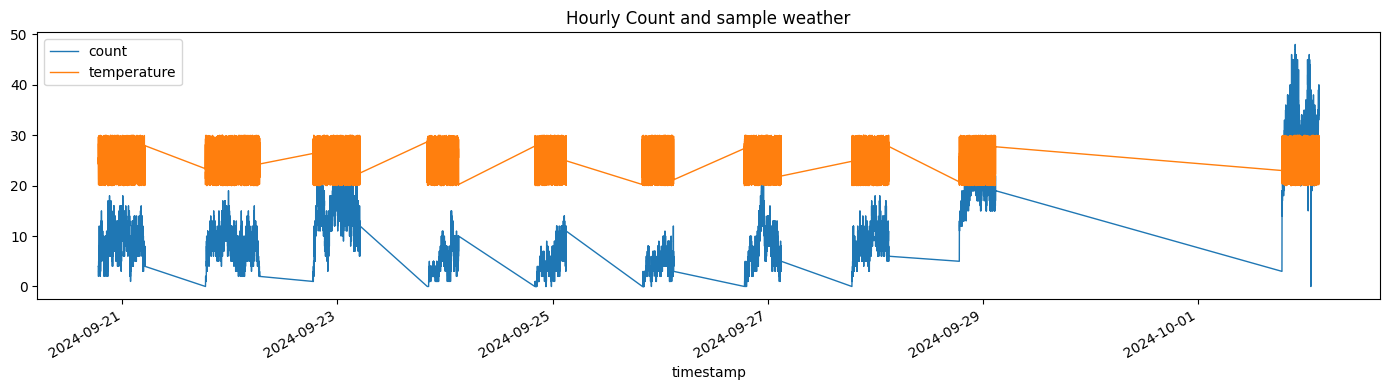

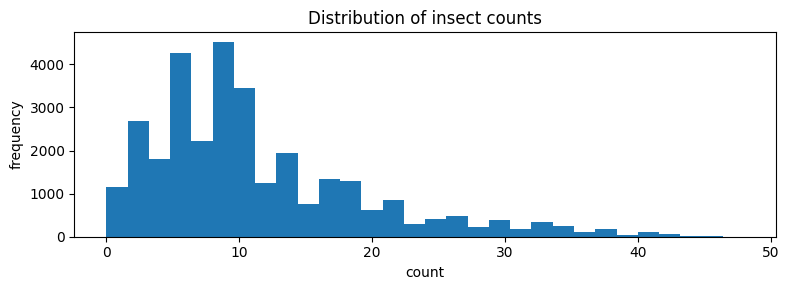

In [10]:

quick_eda(merged)
merged_hourly = merged.copy()

# ---- Visualization ----
temp_cols = [c for c in merged_hourly.columns if 'temp' in c.lower()][:2]
cols_to_plot = ['count'] + temp_cols
plot_time_series_cols(merged_hourly, cols=cols_to_plot, title="Hourly Count and sample weather")

plot_count_histogram(merged_hourly)


Shape: (31279, 4)


,count,temperature,humidity,rain
timestamp,,,,
2024-09-20 18:39:09,4,25.488135,70.633761,False
2024-09-20 18:39:19,4,27.151894,74.718997,False
2024-09-20 18:39:29,4,26.027634,54.860560,False
2024-09-20 18:39:39,4,25.448832,64.028714,False
2024-09-20 18:39:49,3,24.236548,72.116231,False
2024-09-20 18:39:59,4,26.458941,63.943774,False
2024-09-20 18:40:09,4,24.375872,89.312093,False
2024-09-20 18:40:19,4,28.917730,88.706768,False
2024-09-20 18:40:29,3,29.636628,70.434889,False



Missing fractions:


,0



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
count,31279.0,11.220212,8.213001,0.000000,6.000000,9.000000,15.000000,48.000000
temperature,31279.0,24.971337,2.900865,20.000724,22.452236,24.973506,27.489530,29.999780
humidity,31279.0,64.954499,14.397634,40.004543,52.407575,64.963993,77.443467,89.998411


timestamp column missing, cannot resample


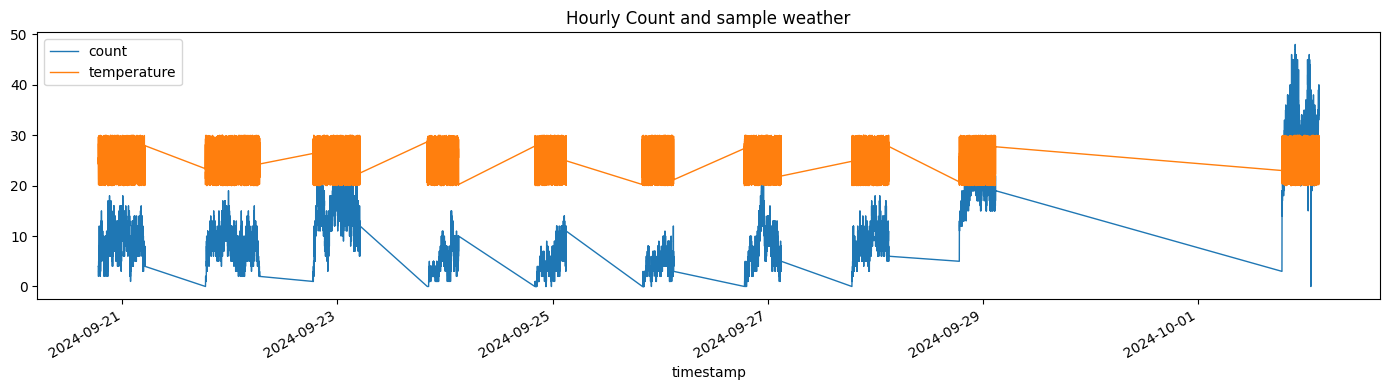

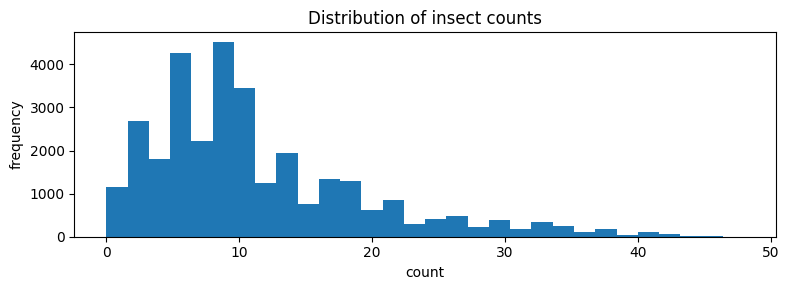

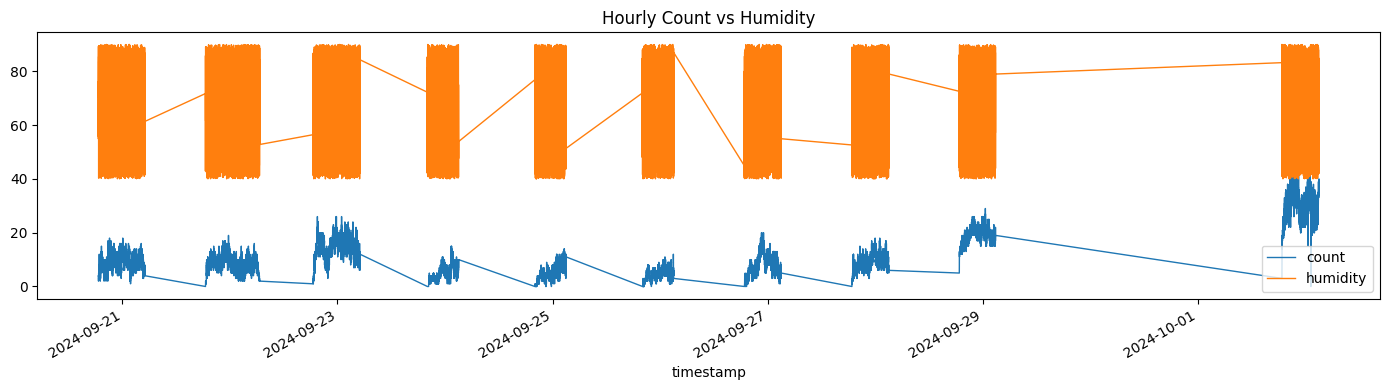

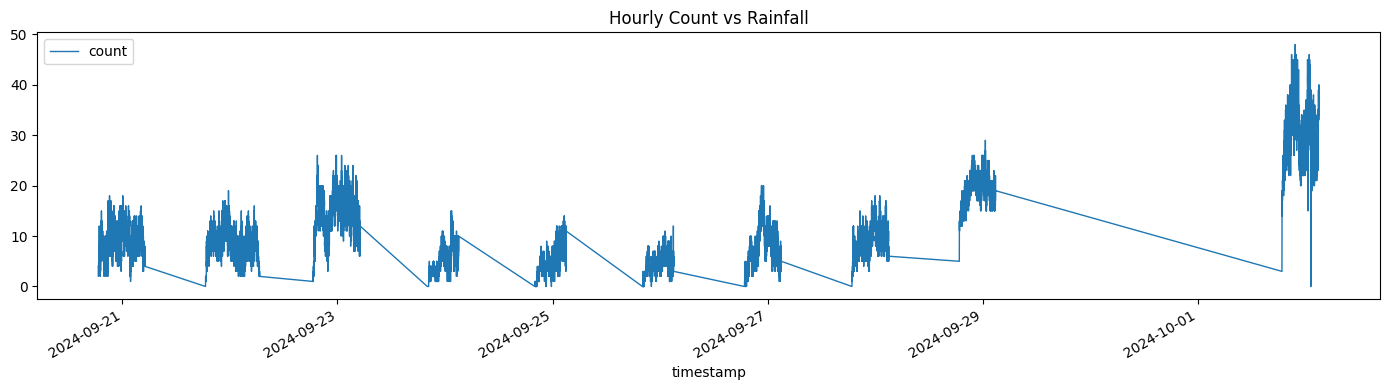

In [11]:
if 'quick_eda' in globals():
    quick_eda(merged)
else:
    print("quick_eda missing; showing head and describe")
    display(merged.head())
    display(merged.describe().T)

# ---- New: aggregate per hour ----
if 'timestamp' in merged.columns:
    merged_hourly = merged.set_index('timestamp').resample('1H').mean(numeric_only=True).reset_index()
    merged_hourly['count'] = merged.set_index('timestamp')['count'].resample('1H').sum().values
else:
    merged_hourly = merged.copy()
    print("timestamp column missing, cannot resample")

# ---- Visualization ----
try:
    temp_cols = [c for c in merged_hourly.columns if 'temp' in c.lower()][:2]
    cols_to_plot = ['count'] + temp_cols
    plot_time_series_cols(merged_hourly, cols=cols_to_plot, title="Hourly Count and sample weather")
except Exception as e:
    print("plot_time_series_cols failed:", e)

try:
    plot_count_histogram(merged_hourly)
except Exception as e:
    print("plot_count_histogram failed:", e)

# ---- Extra plots for humidity and rainfall ----
try:
    humidity_cols = [c for c in merged_hourly.columns if 'humid' in c.lower()][:1]
    if humidity_cols:
        plot_time_series_cols(
            merged_hourly,
            cols=['count'] + humidity_cols,
            title="Hourly Count vs Humidity"
        )
except Exception as e:
    print("plot_time_series_cols (humidity) failed:", e)

try:
    rain_cols = [c for c in merged_hourly.columns if 'rain' in c.lower()][:1]
    if rain_cols:
        plot_time_series_cols(
            merged_hourly,
            cols=['count'] + rain_cols,
            title="Hourly Count vs Rainfall"
        )
except Exception as e:
    print("plot_time_series_cols (rainfall) failed:", e)


# Assess: full deep visualizations (Random Plots)

Running deeper visualizations...


/content/MLFC_Fynesse/fynesse/assess.py:272: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/content/MLFC_Fynesse/fynesse/assess.py:374: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  s_rs = s.resample('10S').mean().interpolate()


Cross-correlation plotted for: temperature
Deep visualizations complete.


<Figure size 1200x400 with 0 Axes>

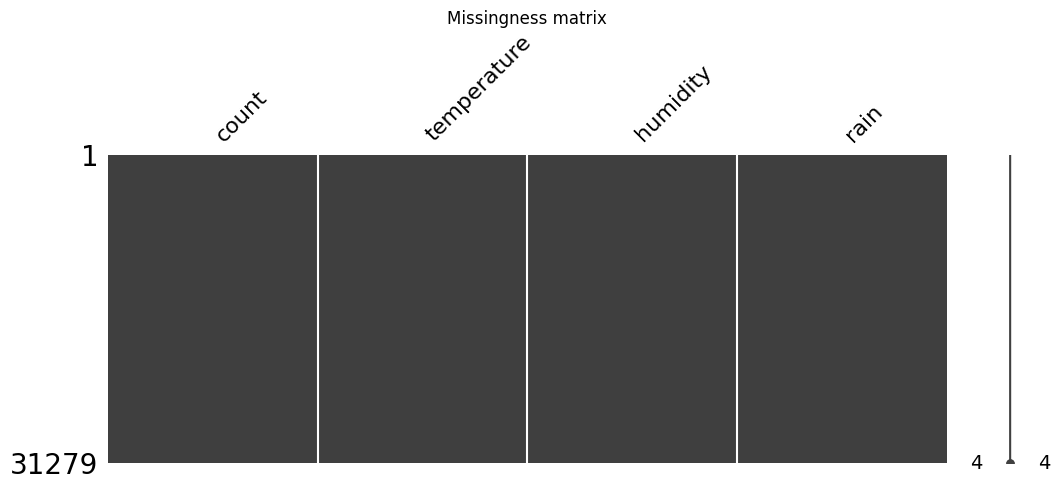

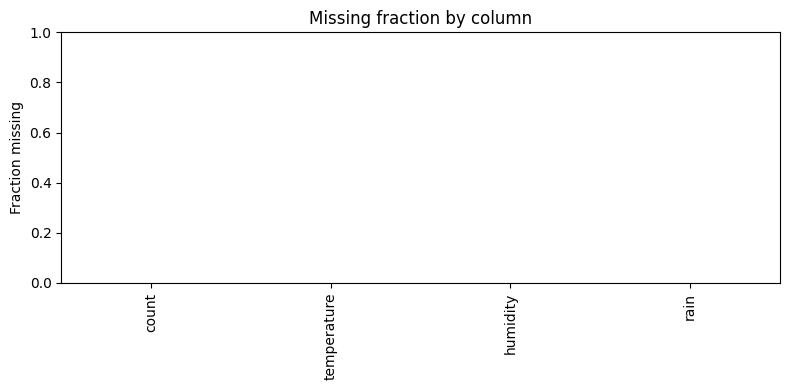

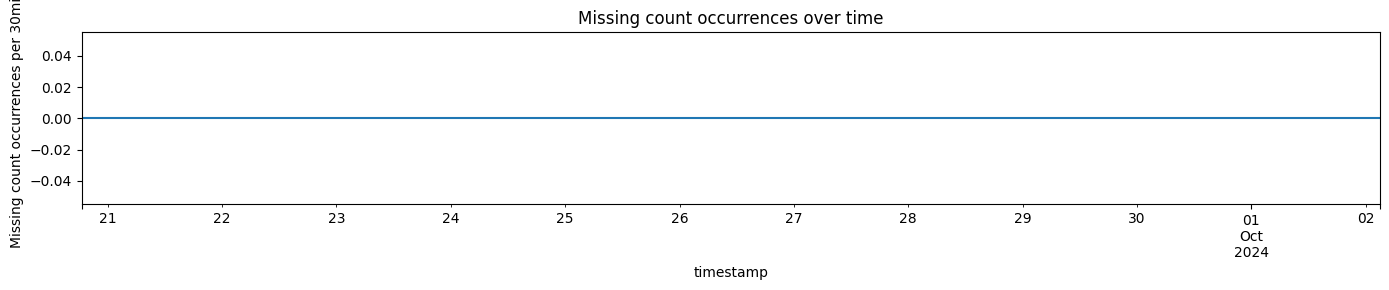

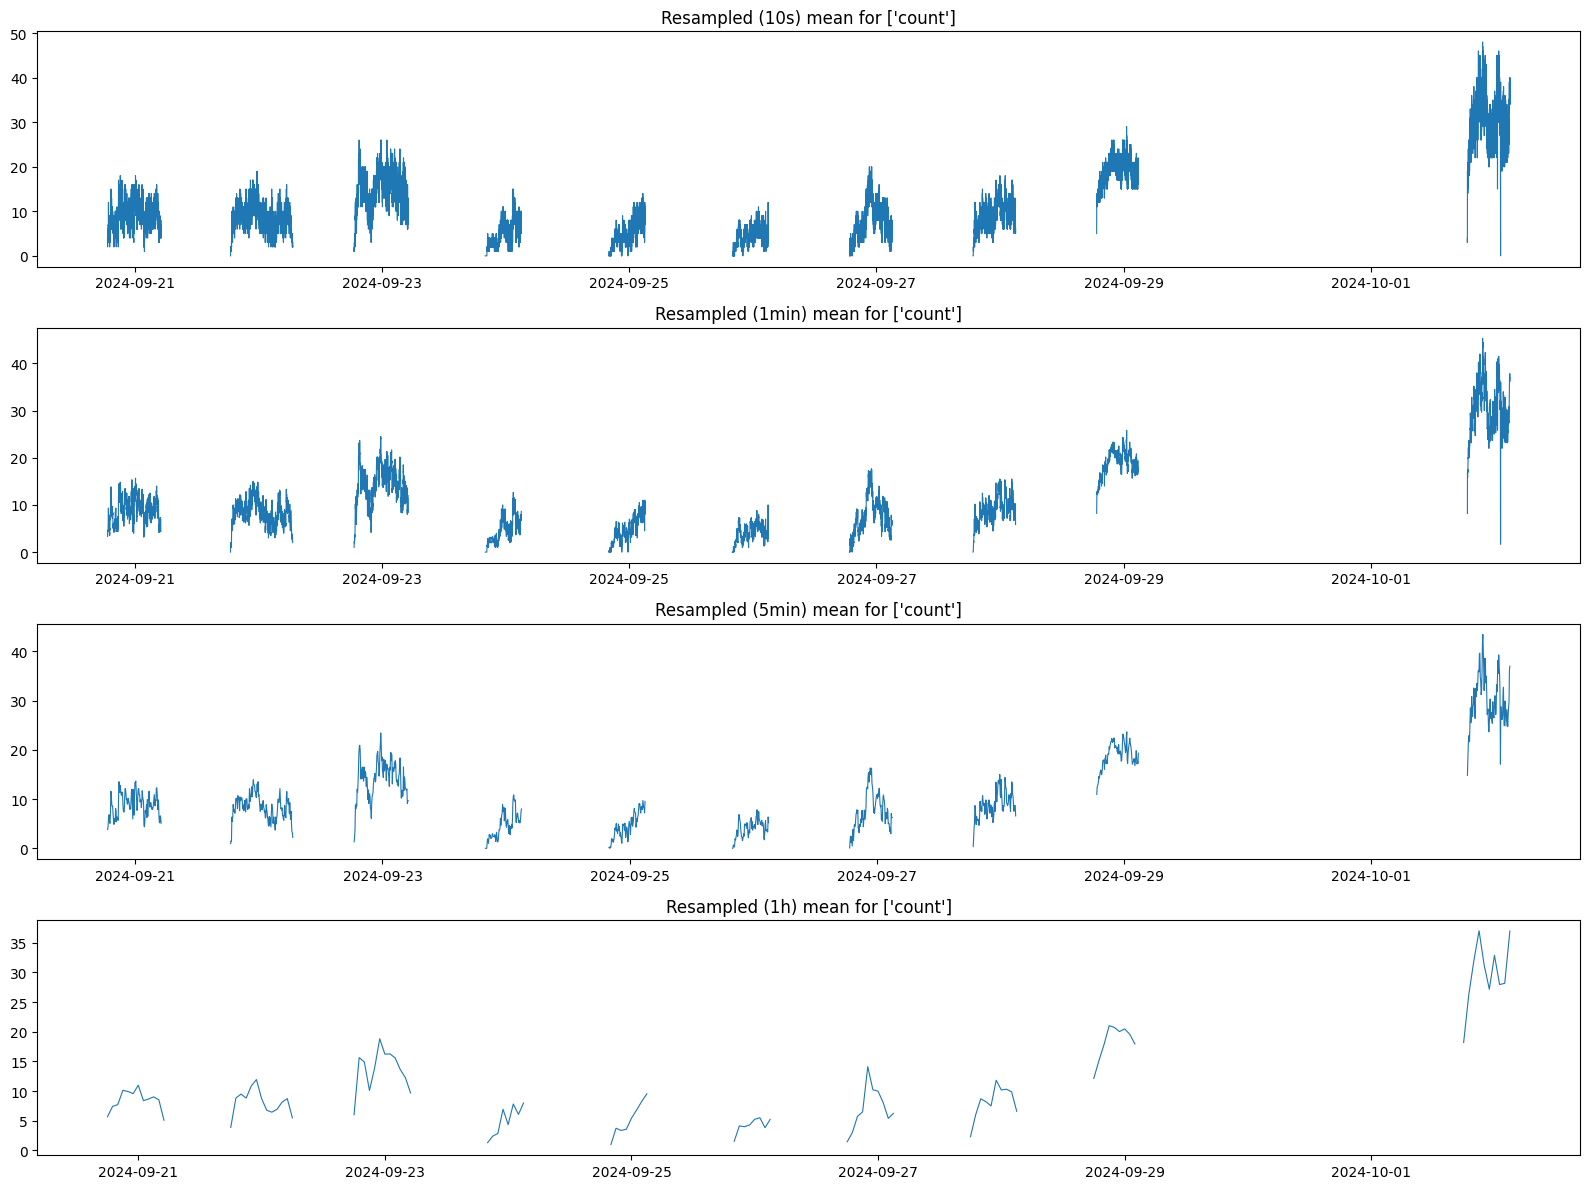

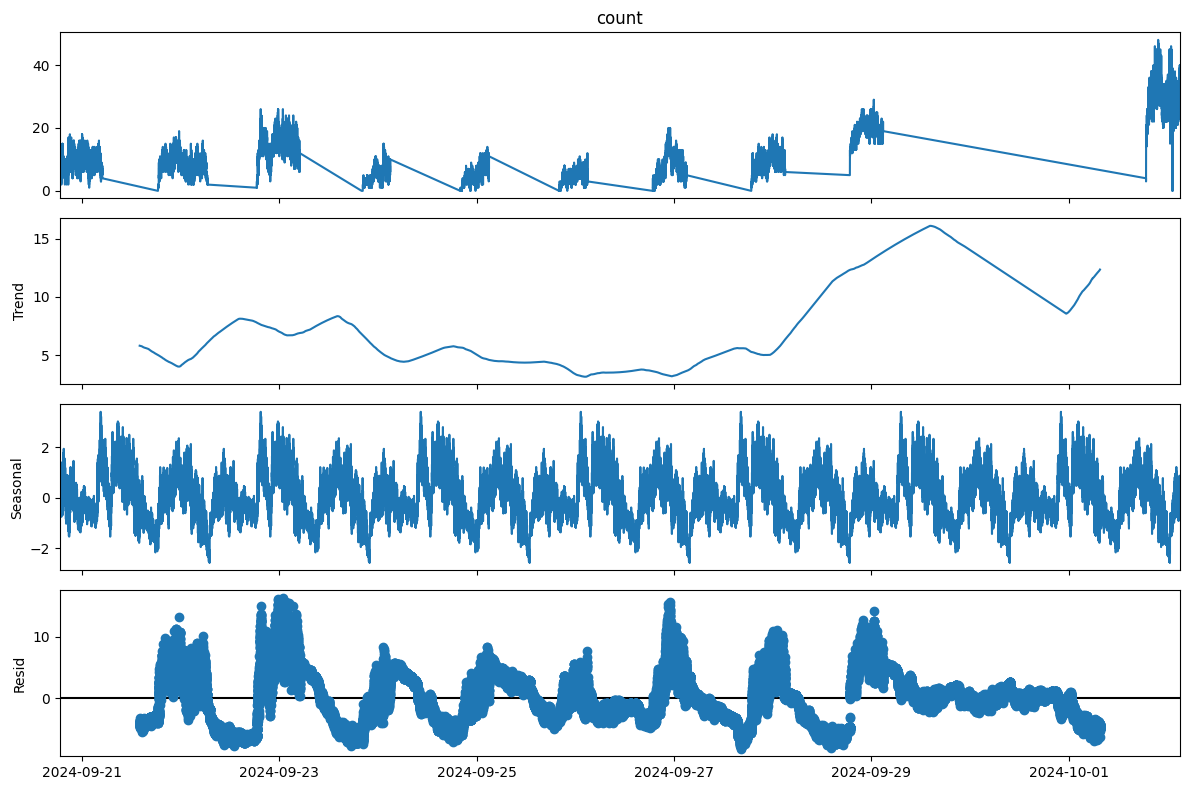

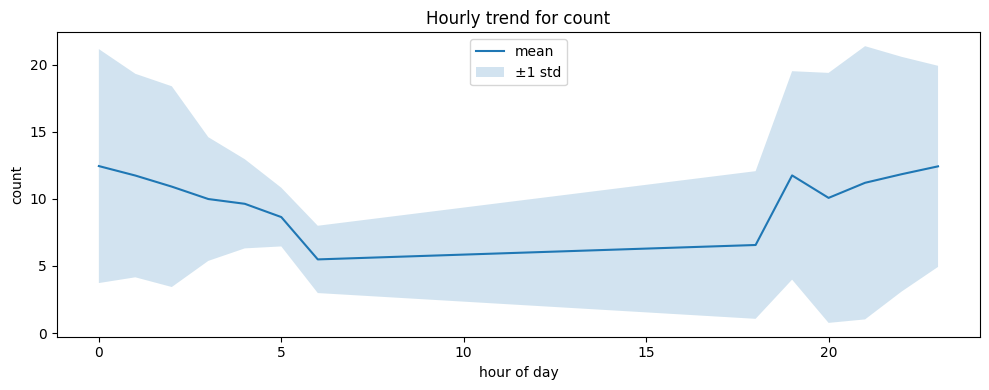

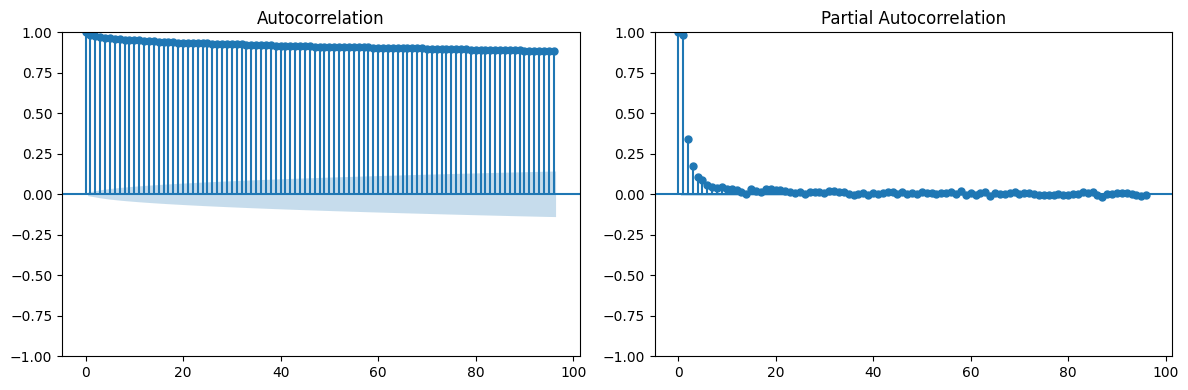

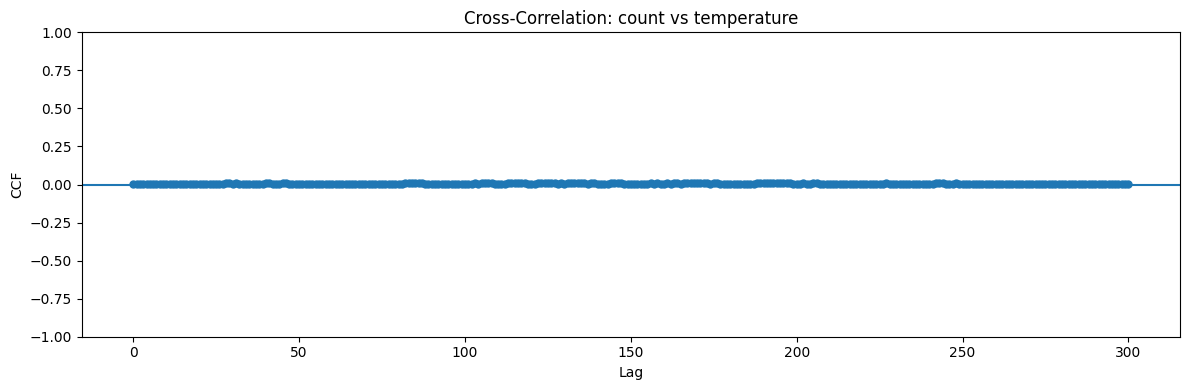

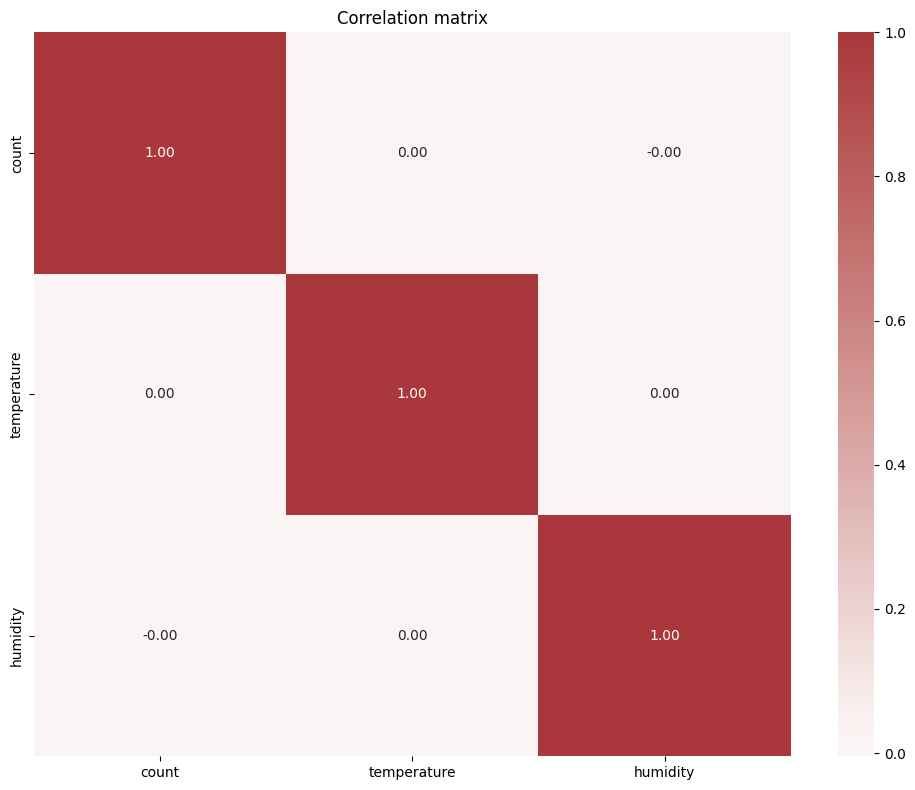

In [12]:
print("Running deeper visualizations...")

# Missingness visuals
fig = plot_missingness_matrix(merged)
fig2 = plot_missingness_bar(merged)
fig3 = plot_time_missing(merged, window='30min')

# Temporal: multi-scale + hourly
fig6 = plot_multi_scale_time_series(
    merged,
    cols=['count'],
    resample_rules=['10s','1min','5min','1h']  # lowercase rules
)
fig7, dec_res = seasonal_decompose_and_plot(merged['count'], freq=None, model='additive')
fig8 = plot_hourly_trends(merged, col='count')

# ACF / PACF
fig9 = plot_acf_pacf_series(merged['count'], lags=96)

# Cross-correlation with first candidate weather variable
weather_candidates = [c for c in merged.columns if any(k in c.lower() for k in ['temp','humid','rain','wind'])]
if weather_candidates:
    col_w = weather_candidates[0]

    # --- FIX: handle missing 'timestamp' column ---
    if 'timestamp' in merged.columns:
        df_for_xcorr = merged.set_index('timestamp')
    else:
        df_for_xcorr = merged.copy()
        if not isinstance(df_for_xcorr.index, pd.DatetimeIndex):
            print("Warning: No datetime index or 'timestamp' column found for crosscorr.")

    fig10 = plot_crosscorr(df_for_xcorr, 'count', col_w, maxlags=300)
    print("Cross-correlation plotted for:", col_w)
else:
    print("No weather candidate columns for crosscorr.")

# Correlations / PCA
fig11 = plot_corr_matrix(merged, figsize=(10,8), cluster=False)

print("Deep visualizations complete.")


# Address: feature engineering & prepare X,y

In [13]:

import numpy as np # Import numpy


X, y = prepare_features_for_model(merged, target_col='count')
scaler = None

print("Feature matrix X shape:", X.shape, "Target y shape:", y.shape)
display(X.head())

Feature matrix X shape: (31279, 2) Target y shape: (31279,)


,temperature,humidity
timestamp,,
2024-09-20 18:39:09,25.488135,70.633761
2024-09-20 18:39:19,27.151894,74.718997
2024-09-20 18:39:29,26.027634,54.860560
2024-09-20 18:39:39,25.448832,64.028714
2024-09-20 18:39:49,24.236548,72.116231


# Address: train/test split and optional scaling

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
print("Train shapes:", X_train.shape, y_train.shape, "Test shapes:", X_test.shape, y_test.shape)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
# we'll keep both scaled and unscaled; many tree models prefer unscaled


Train shapes: (25023, 2) (25023,) Test shapes: (6256, 2) (6256,)


# Address: train regressors (uses train_regressors or train_models)

In [15]:
fitted_regs = train_regressors(X_train, y_train)
print("Trained regressors:", list(fitted_regs.keys()))


Training: LinearRegression
Training: Ridge
Training: RandomForest
Training: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:46:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Trained regressors: ['LinearRegression', 'Ridge', 'RandomForest', 'XGBoost']


Regression metrics:


,model,MSE,RMSE,R2,MAE
1,Ridge,70.271623,8.382817,-0.001097,6.318013
0,LinearRegression,70.271623,8.382817,-0.001097,6.318013
3,XGBoost,77.476128,8.802052,-0.103733,6.640900
2,RandomForest,80.315314,8.961881,-0.144180,6.800563


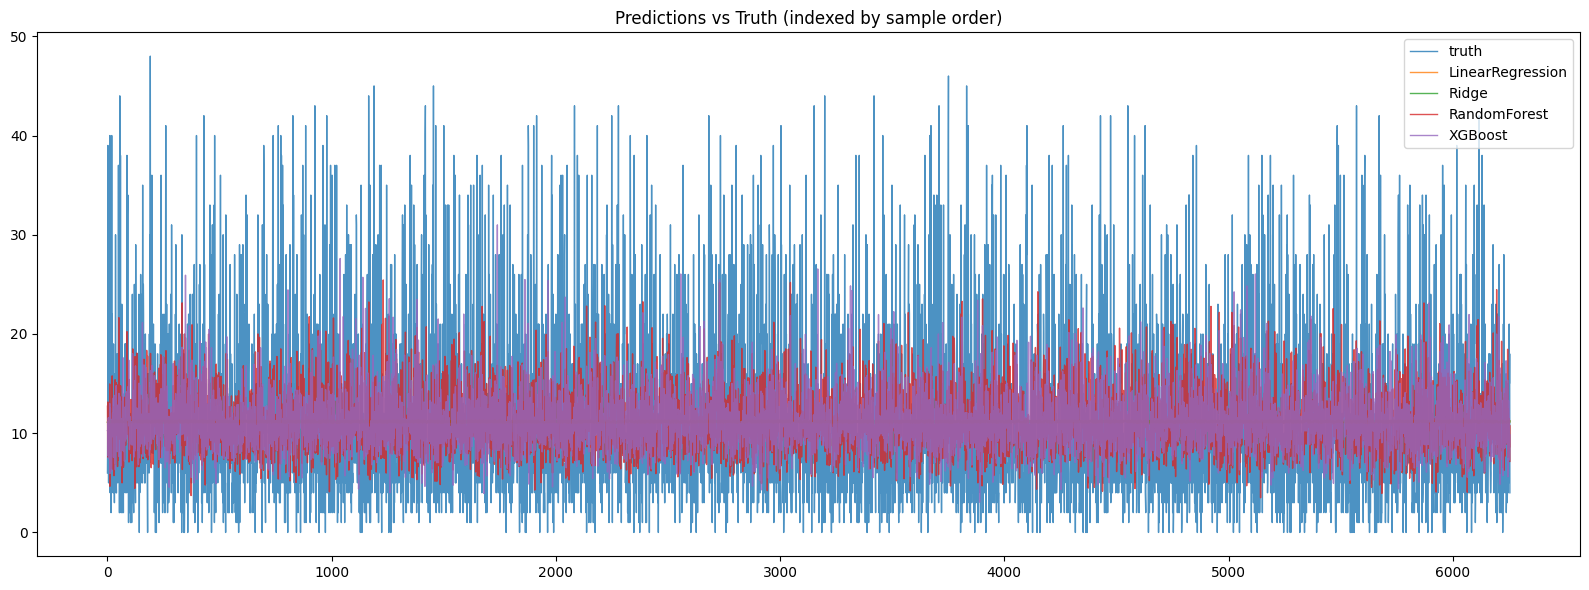

In [16]:
metrics_df, preds = evaluate_regression_models(fitted_regs, X_test, y_test)

print("Regression metrics:")
display(metrics_df)

plot_predictions_vs_truth(y_test.reset_index(drop=True), preds)



# Address: evaluate regressors and plot

Extended Address Visualizations...
plot_residuals failed: name 'sns' is not defined


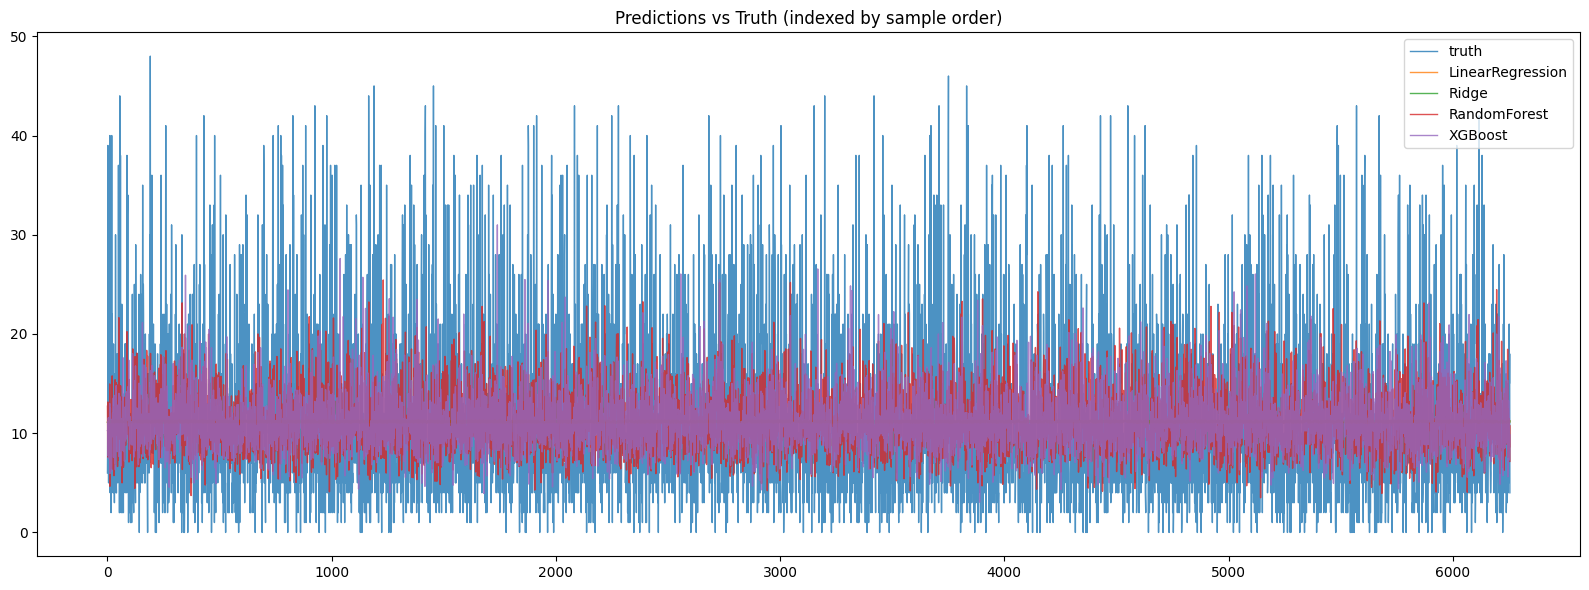

<Figure size 1200x400 with 0 Axes>

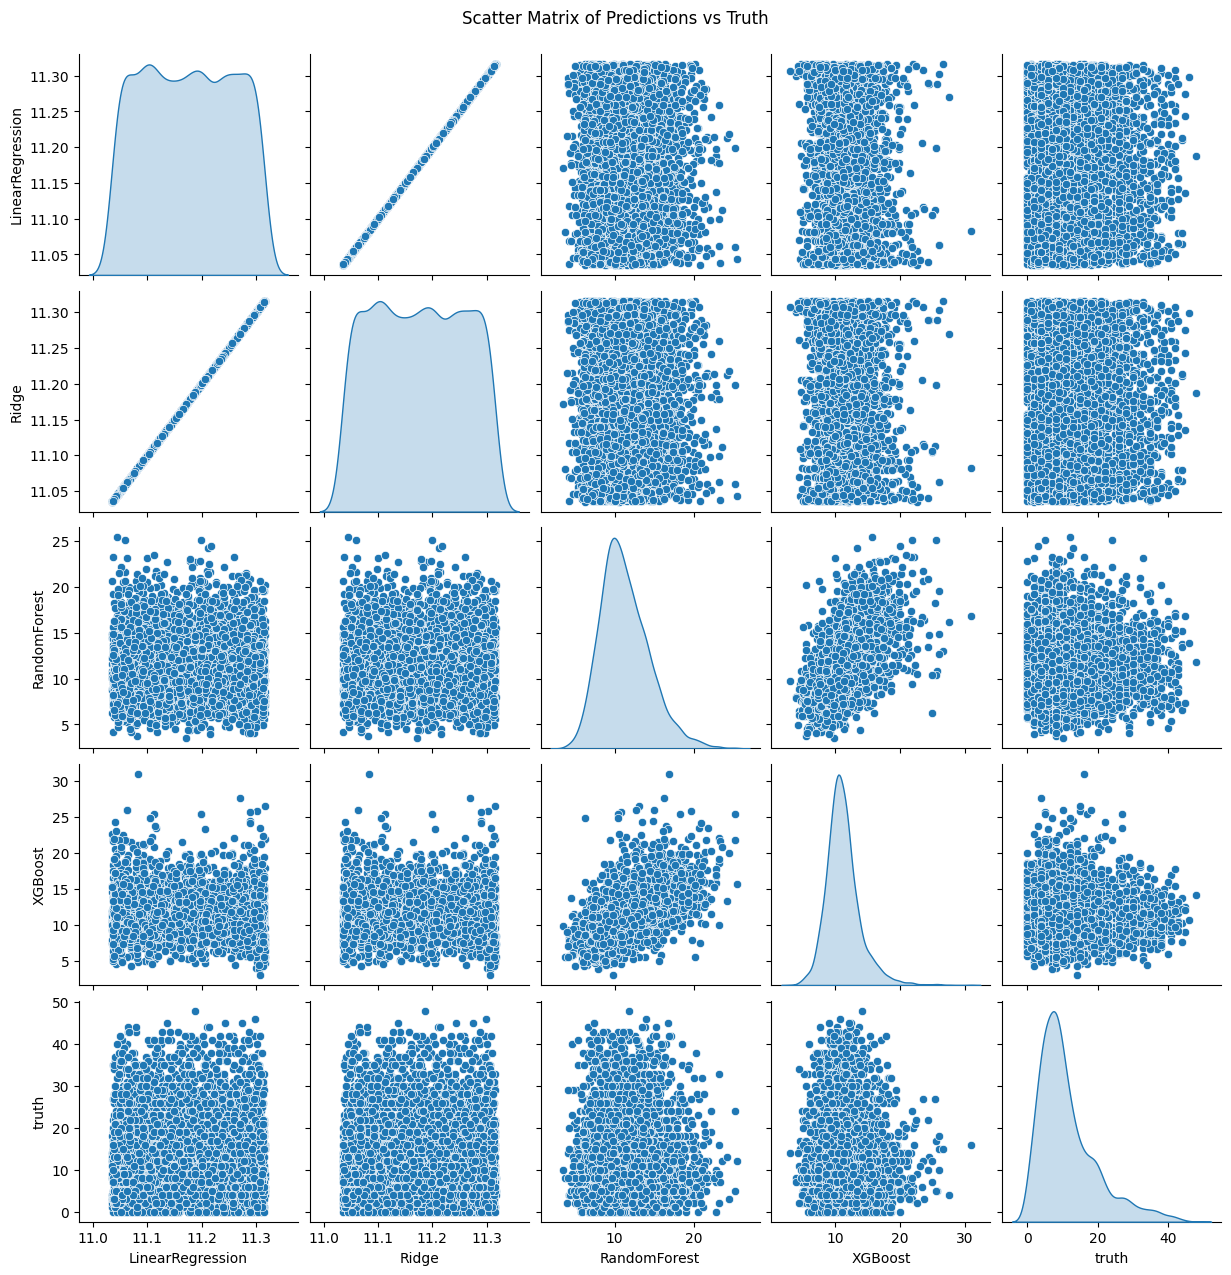

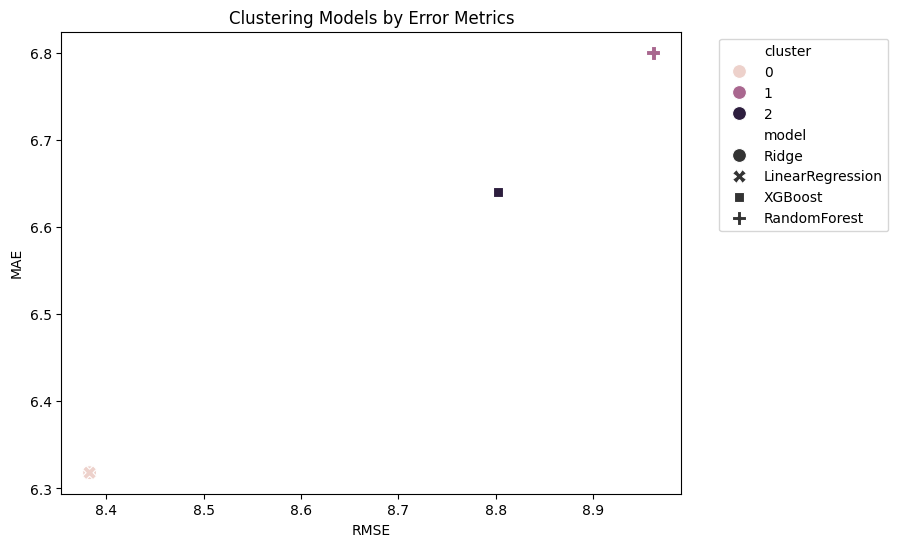

,model,MSE,RMSE,R2,MAE,cluster
1,Ridge,70.271623,8.382817,-0.001097,6.318013,0
0,LinearRegression,70.271623,8.382817,-0.001097,6.318013,0
3,XGBoost,77.476128,8.802052,-0.103733,6.640900,2
2,RandomForest,80.315314,8.961881,-0.144180,6.800563,1


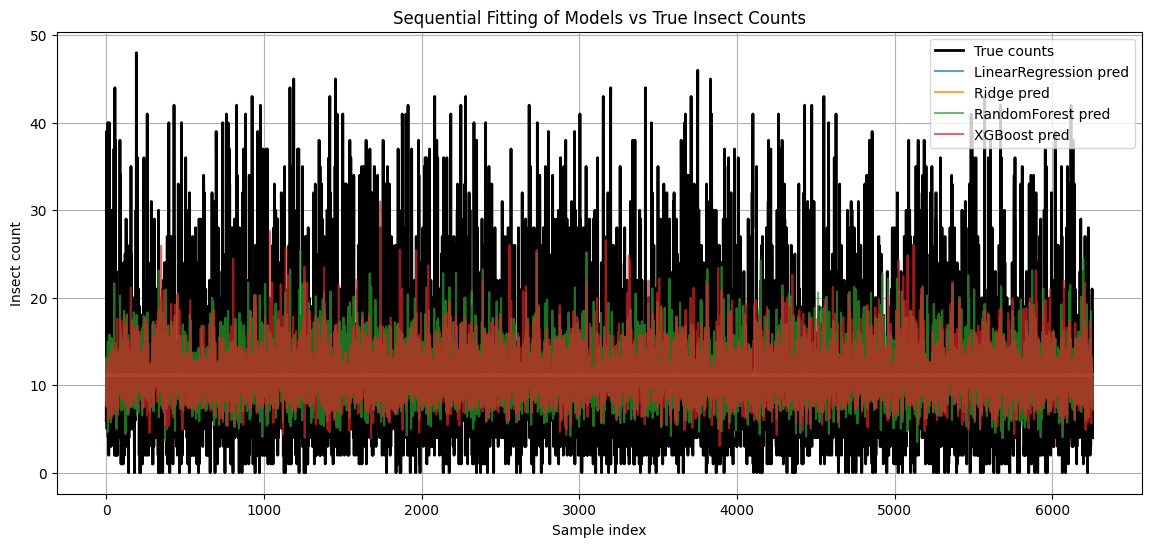

In [17]:
# --- Post Cell 10: Extended Address Visualizations ---

from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

print("Extended Address Visualizations...")

# 1. Predictions vs Truth scatter (already in fynesse helpers)
try:
    plot_predictions_vs_truth(y_test.reset_index(drop=True), preds)
except Exception as e:
    print("plot_predictions_vs_truth failed:", e)

# 2. Residual plots
try:
    plot_residuals(y_test, preds)
except Exception as e:
    print("plot_residuals failed:", e)

# 3. Scatter matrix of predictions vs truth
try:
    pred_df = pd.DataFrame(preds)
    pred_df['truth'] = y_test.reset_index(drop=True)
    sns.pairplot(pred_df, diag_kind="kde")
    plt.suptitle("Scatter Matrix of Predictions vs Truth", y=1.02)
    plt.show()
except Exception as e:
    print("scatter matrix failed:", e)

# 4. Clustering models by their error profiles
try:
    metrics_only = metrics_df[['RMSE', 'MAE', 'R2']].copy()
    km = KMeans(n_clusters=min(3, len(metrics_only)), random_state=42).fit(metrics_only)
    metrics_df['cluster'] = km.labels_

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=metrics_df, x="RMSE", y="MAE",
        hue="cluster", style="model", s=100
    )
    plt.title("Clustering Models by Error Metrics")
    plt.xlabel("RMSE")
    plt.ylabel("MAE")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    display(metrics_df)
except Exception as e:
    print("clustering visualization failed:", e)

# 5. (Optional) Sequential fitting plot if time index is meaningful
try:
    from matplotlib import pyplot as plt
    plt.figure(figsize=(14,6))
    plt.plot(y_test.reset_index(drop=True).values, label="True counts", linewidth=2, color="black")
    for name, y_pred in preds.items():
        plt.plot(y_pred, label=f"{name} pred", alpha=0.7)
    plt.title("Sequential Fitting of Models vs True Insect Counts")
    plt.xlabel("Sample index")
    plt.ylabel("Insect count")
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print("Sequential fitting plot failed:", e)
